In [3]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import NMF
from random import random
import matplotlib.pyplot as plt
import boruta
import process_data

In [4]:
my_data=process_data.process('all_data.csv')
X,y=process_data.split_x_y(my_data)

In [213]:
from sklearn.preprocessing import StandardScaler
X_s=StandardScaler().fit_transform(X)

### XGboost & shap values

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)
XGBoost=GradientBoostingClassifier(n_estimators=100)
XGBoost=XGBoost.fit(X_train,y_train)

In [4]:
y_pred=XGBoost.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score
y_pred_train=XGBoost.predict(X_train)
print('accuracy ',accuracy_score(y_pred=y_pred_train,y_true=y_train))

accuracy  1.0


In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy ',accuracy_score(y_pred=y_pred,y_true=y_test))

accuracy  0.56


In [51]:
import shap
#shap values
# Fits the explainer
explainer = shap.TreeExplainer(XGBoost)
# Evaluate SHAP values
shap_values = explainer.shap_values(X)

ModuleNotFoundError: No module named 'shap'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


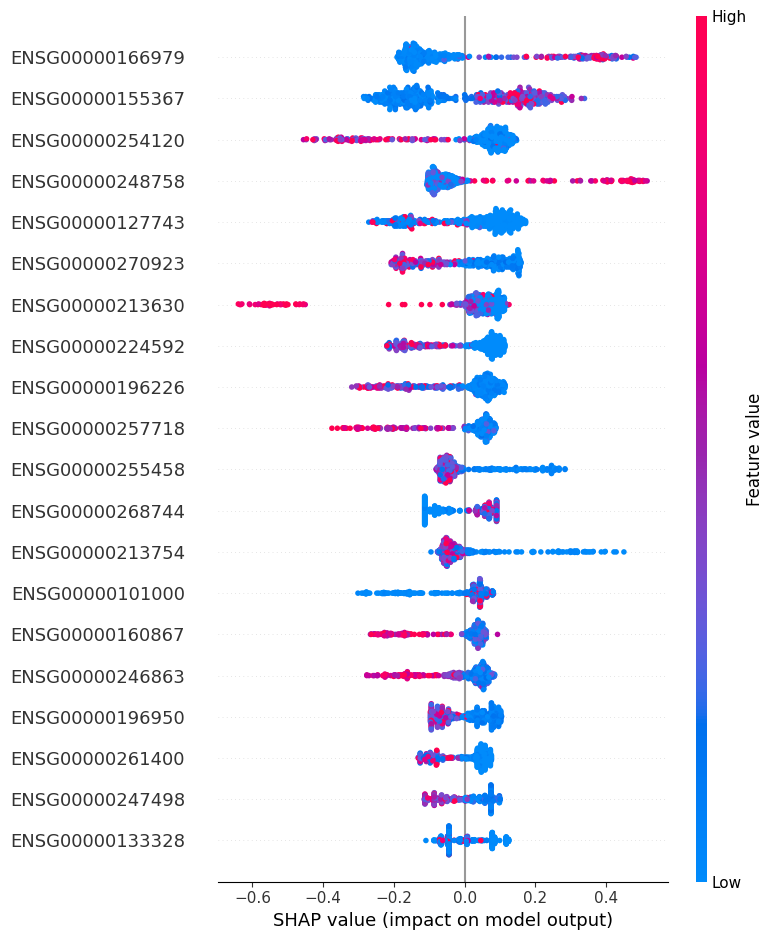

In [ ]:
shap.summary_plot(shap_values,X)

In [46]:
feature_names=X.columns
top_n = 100
abs_shap_values = np.abs(shap_values.mean(axis=0))
top_n_idx = np.argsort(abs_shap_values)[-top_n:]
top_n_features = [feature_names[i] for i in top_n_idx]

print("Top %d features: %s" % (top_n, top_n_features))


NameError: name 'shap_values' is not defined

In [ ]:
top_n_features = [feature_names[i] for i in top_n_idx]

In [ ]:
top_n_features

['ENSG00000155367',
 'ENSG00000269089',
 'ENSG00000152133',
 'ENSG00000206898',
 'ENSG00000189091']

### Feature selection using Lasso

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.svm import LinearSVC

#### SVM with linear kernel

In [234]:
lsvc=LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_s,y)

In [254]:
importance=np.abs(lsvc.coef_).flatten()
feature_names=np.array(X.columns)

<Figure size 4000x15000 with 0 Axes>

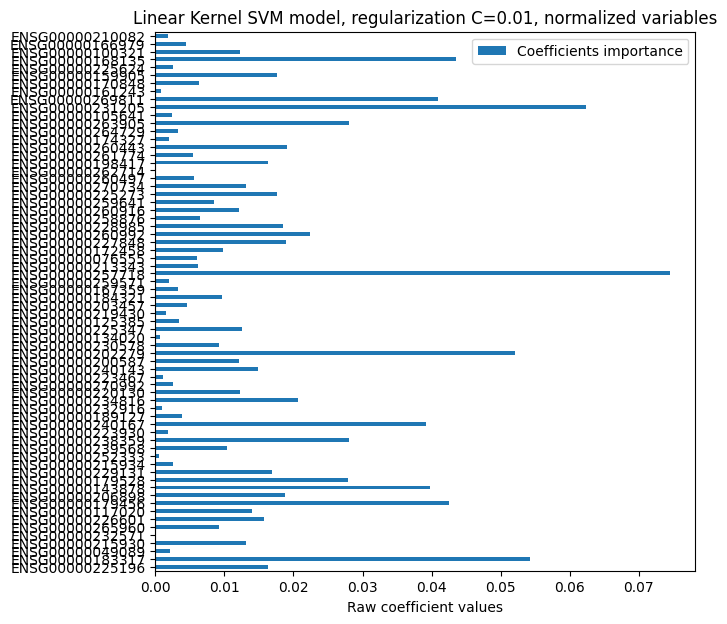

In [263]:
coefs = pd.DataFrame(
    importance[importance!=0],
    columns=["Coefficients importance"],
    index=feature_names[importance!=0],
)

plt.figure(figsize=(40,150))
coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Kernel SVM model, regularization C=0.01, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [240]:
gene_list_svc=np.where([importance!=0])[1]

In [268]:
features_svc=feature_names[gene_list_svc]

#### Lasso linear model

In [241]:
lasso=LassoCV(alphas=np.linspace(0.1,0.2,100)).fit(X_s,y)

In [242]:
lasso.alpha_

0.1191919191919192

In [243]:
importance=np.abs(lasso.coef_)
feature_names=np.array(X.columns)

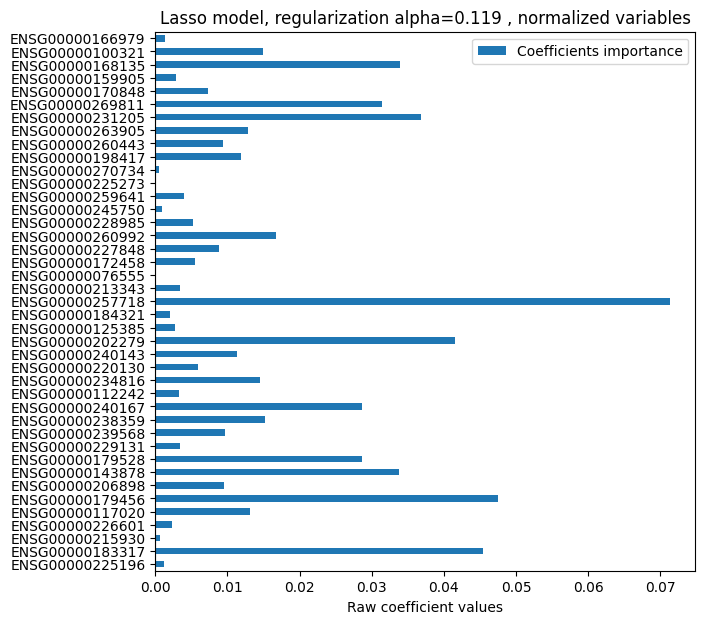

In [244]:
coefs = pd.DataFrame(
    importance[importance!=0],
    columns=["Coefficients importance"],
    index=feature_names[importance!=0],
)

coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, regularization alpha=0.119 , normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


In [245]:
gene_list_lasso=np.where([importance!=0])[1]

In [ ]:
gene_list_lasso.to_csv('/home/irit/Documents/Projet Myelome/features_lasso.csv')

In [265]:
pd.DataFrame(gene_list_svc).to_csv('/home/irit/Documents/Projet Myelome/features_svc.csv')

In [309]:
features_lasso=pd.DataFrame(feature_names[gene_list_lasso]).values.flatten().tolist()

In [279]:
pd.DataFrame(feature_names[gene_list_lasso]).to_csv('/home/irit/Documents/Projet Myelome/features_lasso.csv')

In [319]:
features_svc=feature_names[gene_list_svc].tolist()

In [281]:
pd.DataFrame(features_svc).to_csv('/home/irit/Documents/Projet Myelome/features_svc.csv')

In [289]:
identified_genes=list(pd.read_csv('identified_genes_panel_routine.csv').values[:,1])